In [1]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
import pandas as pd

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [2]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

In [3]:
def tica(data, lagtime, var_cutoff):
    '''RETURNS: projected data on tics, tica object
    '''
    est = TICA(lagtime=lagtime, var_cutoff = var_cutoff).fit(data)
    tica = est.fetch_model()
    plt.scatter(np.arange(5),tica.singular_values[:5])
    plt.xticks(np.arange(5),np.arange(5))
    plt.title("Eigen Values")
    return tica.transform(data), tica
def kmeans(p,k):
    '''RETURNS: dtraj, frames_cl, clustercenters
    '''
    cluster = KMeans(k,max_iter=1000).fit_fetch(p)
    dtraj = cluster.transform(p)
    frames_cl = []
    for i in range(k):
        frames = np.where(dtraj==i)[0]
        frames_cl.append(frames)
    return dtraj,frames_cl,cluster.cluster_centers
def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>space]+i*nres)
    return np.hstack(l)

In [15]:
outdir = '/Users/achakrab/Documents/asn/tica'
pdb = '/home/apara/Documents/asn/biorxiv2021-6626290-no-water-glue/lig47.pdb'
rep0 = '/home/apara/Documents/asn/biorxiv2021-6626290-no-water-glue/ligand_47_1.xtc'
#helixpdb = './Trajectory_Files_12.20.21/R2R3_all_helix.pdb'
#apodir = './Trajectory_Files_12.20.21/R2_R3_APO/'

table,bonds = md.load(pdb).topology.to_dataframe()
first = table[table["resSeq"]==121].to_numpy()
first[:,0] = np.arange(1, 1+len(first))
second = table[table["resSeq"]!=121].to_numpy()
second[:,0] = np.arange(first[-1,0]+1, first[-1,0]+1 + len(second))
final = np.concatenate([first, second], axis=0)
df = pd.DataFrame(data = final, columns = table.columns)
top_fix = md.Topology.from_dataframe(df, bonds)
trj = md.load(rep0, top =top_fix)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames

In [16]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)


residue_offset = 0
prot_res_renum = np.asarray(prot_res)+residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)



** SYSTEM INFO **

Number of atoms: 338

Number of residues: 21

Number of protein residues: 20

Number of frames: 1100889

Starting frame: 0

Last frame: 1100889

sequence:  [ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140, <1>1]

residue names:  ['ASP', 'ASN', 'GLU', 'ALA', 'TYR', 'GLU', 'MET', 'PRO', 'SER', 'GLU', 'GLU', 'GLY', 'TYR', 'GLN', 'ASP', 'TYR', 'GLU', 'PRO', 'GLU', 'ALA', '<1>']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]



In [5]:
for i in range(trj.n_residues):print([trj.topology.atom(i) for i in trj.topology.select(f"resid {i}")], "\n")

[ASP121-N, ASP121-CA, ASP121-C, ASP121-O, ASP121-CB, ASP121-CG, ASP121-OD1, ASP121-OD2, ASP121-H, ASP121-HA, ASP121-HB2, ASP121-HB3, ASP121-H, ASP121-H] 

[ASN122-N, ASN122-CA, ASN122-C, ASN122-O, ASN122-CB, ASN122-CG, ASN122-OD1, ASN122-ND2, ASN122-H, ASN122-HA, ASN122-HB2, ASN122-HB3, ASN122-HD21, ASN122-HD22] 

[GLU123-N, GLU123-CA, GLU123-C, GLU123-O, GLU123-CB, GLU123-CG, GLU123-CD, GLU123-OE1, GLU123-OE2, GLU123-H, GLU123-HA, GLU123-HB2, GLU123-HB3, GLU123-HG2, GLU123-HG3] 

[ALA124-N, ALA124-CA, ALA124-C, ALA124-O, ALA124-CB, ALA124-H, ALA124-HA, ALA124-HB1, ALA124-HB2, ALA124-HB3] 

[TYR125-N, TYR125-CA, TYR125-C, TYR125-O, TYR125-CB, TYR125-CG, TYR125-CD1, TYR125-CD2, TYR125-CE1, TYR125-CE2, TYR125-CZ, TYR125-OH, TYR125-H, TYR125-HA, TYR125-HB2, TYR125-HB3, TYR125-HD1, TYR125-HD2, TYR125-HE1, TYR125-HE2, TYR125-HH] 

[GLU126-N, GLU126-CA, GLU126-C, GLU126-O, GLU126-CB, GLU126-CG, GLU126-CD, GLU126-OE1, GLU126-OE2, GLU126-H, GLU126-HA, GLU126-HB2, GLU126-HB3, GLU126-HG2, GLU126

In [6]:
#Select Ligand Charge Groups
#Ligand Charged atom is N-296
Ligand_Pos_Charges=[296]
Ligand_Neg_Charges=[]

def add_charge_pair(pairs,pos,neg,contact_prob):
    if pos not in pairs: 
        pairs[pos] = {} 
    if neg not in pairs[pos]:
        pairs[pos][neg] = {}
    pairs[pos][neg] = contact_prob

#Select Protein Charge Groups
#Add Apropriate HIS name if there is a charged HIE OR HIP in the structure 
Protein_Pos_Charges=top.select("(resname ARG and name CZ) or (resname LYS and name NZ) or (resname HIE and name NE2) or (resname HID and name ND1)")
#Protein_Neg_Charges=[]
Protein_Neg_Charges=top.select("(resname ASP and name CG) or (resname GLU and name CD) or (name OXT) or (resname NASP and name CG)")
neg_res=[]
pos_res=[]
                               
for i in Protein_Neg_Charges:
    neg_res.append(top.atom(i).residue.resSeq)

for i in Protein_Pos_Charges:
    pos_res.append(top.atom(i).residue.resSeq)                               
                               
print("Negatively Charged Residues:", neg_res)
print("Posiitively Charged Residues", pos_res)

charge_pairs_ligpos=[]                      
for i in Ligand_Pos_Charges:
    for j in Protein_Neg_Charges:              
        charge_pairs_ligpos.append([i,j])
        pos=top.atom(i)
        neg=top.atom(j) 

contact_1  = md.compute_distances(trj, charge_pairs_ligpos)
#contact_2  = md.compute_distances(trj, charge_pairs_ligneg)


Negatively Charged Residues: [121, 123, 126, 130, 131, 135, 137, 139, 140]
Posiitively Charged Residues []


In [5]:
contact_1 = np.load("/home/apara/Documents/asn/tica/lig_47/charge/charge_dist_matrix.npy")

In [6]:
contact_1.shape

(1100889, 9)

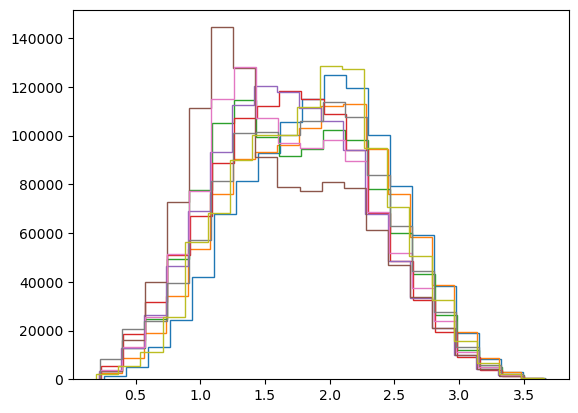

In [7]:
for i in range(0,9):
   plt.hist((contact_1[:,i]),histtype='step',bins=20,label=i) 

np.save("charge_dist_matrix.npy", contact_1)

In [148]:
#dmat_intra = distance_matrix(np.arange(1,21),np.arange(1,21), 0,0,trj,"residues", True)[0]

In [8]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

<Figure size 640x480 with 0 Axes>

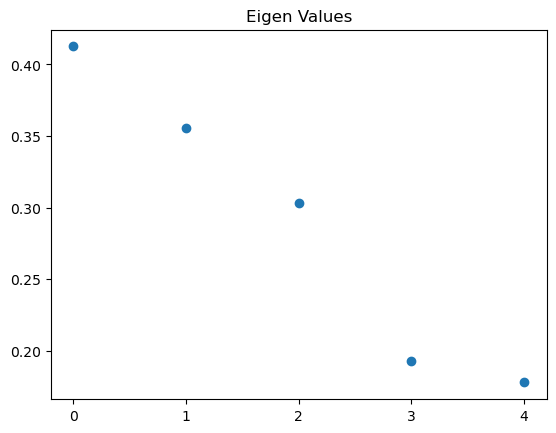

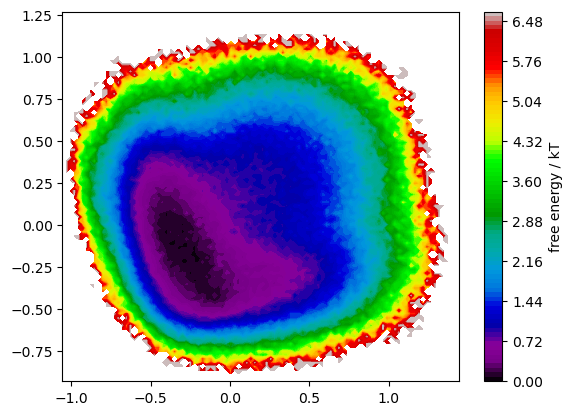

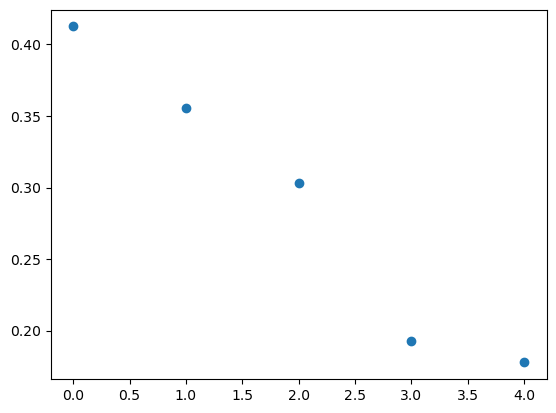

<Figure size 640x480 with 0 Axes>

In [9]:
##adjustable params
space = 1
dim = 2
n_clusters = 4
lag = 50
##
combined = contact_1
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:5])), tica_combined.singular_values[:5])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()

In [10]:
np.save('lig47_charge_tica_combined_10.npy', tica_combined)
np.save('lig47_charge_proj_combined_10.npy', proj_combined)
np.save('lig47_charge_combined_10.npy', dtraj)

In [3]:
dtraj = np.load('lig47_charge_combined_10.npy')

<BarContainer object of 4 artists>

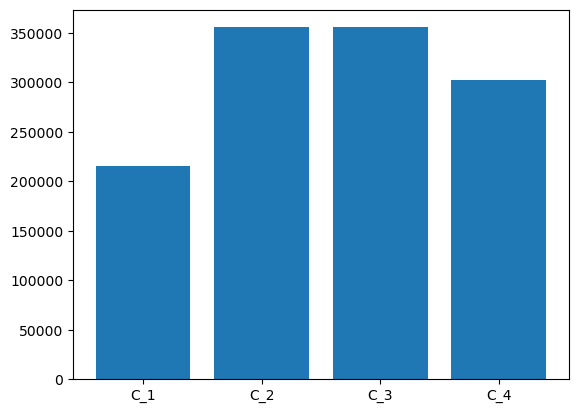

In [11]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

c0 = c0_i.size
c1 = c1_i.size
c2 = c1_i.size
c3 = c3_i.size
size = [c0, c1, c2, c3]
langs = ['C_1', 'C_2', 'C_3', 'C_4']
plt.bar(langs, size)

In [128]:
#np.linalg.norm()

In [100]:
#trj = trj[::10]

In [113]:
make_dcd(trj, clustercenters, dtraj, proj_combined, 2, "cluster.dcds")

In [117]:
wdir = "cluster.dcds"
p = proj_combined[:,:dim]
c = clustercenters[:,:dim]
nc = clustercenters.shape[0]
frames_cl = [np.where(dtraj == i)[0] for i in range(nc)]
all_frames = []
for i in range(nc):
    frames = frames_cl[i][np.argsort([np.linalg.norm(p[j]-c[i]) for j in frames_cl[i]])]
    trj[frames].save_dcd(wdir+f"/cluster.{i+1}.dcd")
    print(frames)
    all_frames.append(frames)

[ 11205  46752  36606 ...  22973 110403  37568]
[103561  22957   4682 ...  29723 100944  52308]
[64285 15477 53937 ... 16361 68088 91897]
[ 35918  48069  18357 ... 106563  82041  42107]


In [97]:
all_frames = np.concatenate(all_frames)

In [98]:
np.sort(all_frames)

array([     0,      1,      2, ..., 111086, 111087, 111088])

In [99]:
trj.n_frames

1110889

In [81]:
print(np.concatenate(all_frames).sort())

None


In [88]:
all_frames.sort()

In [92]:
np.sort(all_frames).astype(int) == np.arange(trj.n_frame

/tmp/ipykernel_9445/1663767015.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.sort(all_frames).astype(int) == np.arange(trj.n_frames).astype(int)


False

In [65]:
proj_combined

array([[0.187, -0.027, 0.175, -0.160],
       [0.057, -0.215, 0.044, -0.033],
       [0.018, -0.217, -0.031, -0.093],
       ...,
       [-0.095, -0.096, 0.115, 0.003],
       [0.131, 0.132, -0.038, -0.018],
       [0.026, -0.213, 0.054, 0.012]])

In [68]:
make_dcd(trj, clustercenters, dtraj, proj_combined, 2, "cluster.dcds")

In [57]:
frames

In [41]:
!ls ./cluster.dcds

cluster.1.dcd  cluster.2.dcd  cluster.3.dcd  cluster.4.dcd


In [42]:
!pwd

/home/apara/Documents/asn/tica/fusadil


In [ ]:
make_dcds

In [43]:
clustercenters

array([[-0.035, -0.152],
       [0.019, 0.131],
       [-0.234, 0.010],
       [0.238, -0.035]])

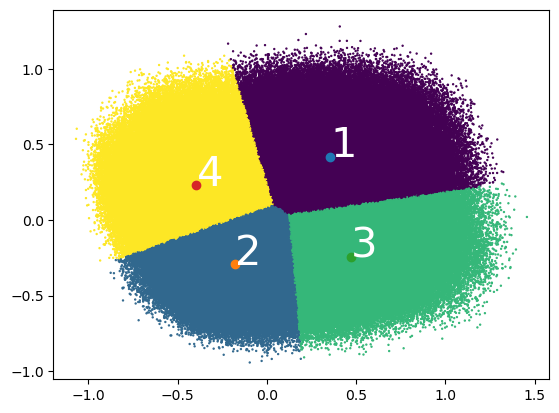

In [12]:
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)
for j,i in enumerate(clustercenters):
    plt.annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")
    
plt.scatter(clustercenters[0,0], clustercenters[0,1])
plt.scatter(clustercenters[1,0], clustercenters[1,1])
plt.scatter(clustercenters[2,0], clustercenters[2,1])
plt.scatter(clustercenters[3,0], clustercenters[3,1])

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


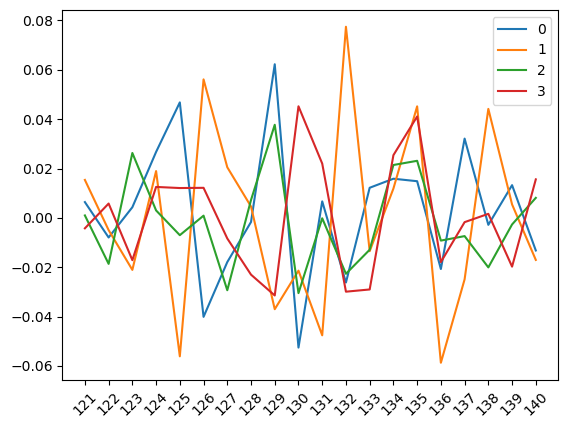

In [46]:
tica_obj = coor.tica(dmat, lag=50)
A = tica_obj.eigenvectors

for i in range(0,4):
 plt.plot(prot_res_renum[0:20],A[:,i],label='%s'%i)

plt.xticks(prot_res,prot_res,rotation=45)
plt.legend()

In [47]:
frames_cl

[array([     1,      2,      3, ..., 111079, 111086, 111088]),
 array([    18,     19,     20, ..., 111084, 111085, 111087]),
 array([     7,     12,     21, ..., 111054, 111073, 111077]),
 array([     0,     14,     15, ..., 111069, 111070, 111080])]

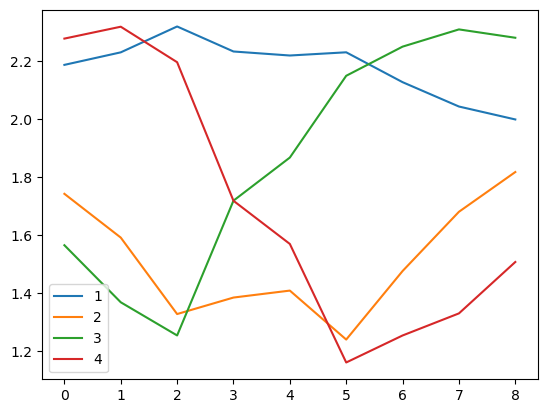

In [13]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(contact_1[c0_i],axis=0),label='1')
plt.plot(np.average(contact_1[c1_i],axis=0),label='2')
plt.plot(np.average(contact_1[c2_i],axis=0),label='3')
plt.plot(np.average(contact_1[c3_i],axis=0),label='4')
plt.legend()
#plt.savefig("fasudil_clusters.png")

In [17]:
trj[frames_cl[0]].save_dcd("/home/apara/Documents/asn/tica/lig_47/charge/lig47_charge_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/home/apara/Documents/asn/tica/lig_47/charge/lig47_charge_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/home/apara/Documents/asn/tica/lig_47/charge/lig47_charge_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/home/apara/Documents/asn/tica/lig_47/charge/lig47_charge_cluster_4.dcd") #save frames

In [18]:
#make tick labels
ticklabs = "1,2,3,4".split(",")
#make custom set of colors for each state
nstates = dtraj.max()+1
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

In [19]:
#make instance of bayesian MSM  to estimate errors from bootstrapping (gibbs sampling)
lagtime = 10
bmsm = pyemma.msm.bayesian_markov_model(dtraj,lagtime,nsamples=10)    
ck = bmsm.cktest(nstates-1,memberships = np.eye(nstates),n_jobs=1,)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[0]: Sampling MSMs:   0%|                                       …

estimating BayesianMSM:   0%|                                                                                 …

In [20]:
#customize pyemma source code
def _add_ck_subplot(cktest, test_index, ax, i, j, ipos=None, jpos=None, y01=True, units='steps', dt=1., **plot_kwargs):
    # plot estimates
    for default in ['color', 'linestyle']:
        if default in plot_kwargs.keys():
            #print("ignoring plot_kwarg %s: %s"%(default, plot_kwargs[default]))
            plot_kwargs.pop(default)
    color = clist[1] ####this is added######

    lest = ax.plot(dt*cktest.lagtimes, cktest.estimates[:, i, j], color="black", **plot_kwargs)
    # plot error of estimates if available
    if cktest.has_errors and cktest.err_est:
        ax.fill_between(dt*cktest.lagtimes, cktest.estimates_conf[0][:, i, j], cktest.estimates_conf[1][:, i, j],
                        color='black', alpha=0.2)
    # plot predictions
    lpred = ax.plot(dt*cktest.lagtimes, cktest.predictions[:, i, j], color=color, linestyle='dashed', **plot_kwargs)
    # plot error of predictions if available
    if cktest.has_errors:
        ax.fill_between(dt*cktest.lagtimes, cktest.predictions_conf[0][:, i, j], cktest.predictions_conf[1][:, i, j],
                        color=color, alpha=0.2)
    # add label
    ax.text(0.1, 0.8, str(i+1)+' ->'+str(j+1), transform=ax.transAxes, weight='bold')
    if y01:
        ax.set_ylim(0, 1)
    # Axes labels
    if ipos is None:
        ipos = i
    if jpos is None:
        jpos = j
    if (jpos == 0):
        ax.set_ylabel('probability')
    if (ipos == cktest.nsets-1):
        ax.set_xlabel('lag time (' + units + ')')
    # return line objects
    return lest, lpred


def plot_cktest(cktest, figsize=None, diag=False,  y01=True, layout=None,
                padding_between=0.1, padding_top=0.075, units='steps', dt=1., **plot_kwargs):
    """Plot of Chapman-Kolmogorov test
    Parameters
    ----------
    cktest : msm.ChapmanKolmogorovValidator or list of msm.ChapmanKolmogorovValidator
        Chapman-Kolmogorov Test, optionally a list of tests which are all 
        plotted into the same set of axes. This assumes that all cktests were
        estimated for the same nstates.
    figsize : shape, default=(10, 10)
        Figure size
    diag : bool, default=False
        Plot only diagonal elements of the test, i.e. self-transition
        probabilities.
    y01 : bool, default=True
        Scale all y-Axes to [0,1]. If True, the y-Axes can be shared
        and the figure is tighter. If False, each y Axis will be scaled
        automatically.
    layout : str or shape or None, default=None
        Organization of subplots. You can specify your own shape. If None,
        an automatic shape will be selected. Use 'wide' for plots that
        span the page width (double-column figures) and 'tall' for
        single-column figures.
    padding_between : float, default=0.1
        padding space between subplots (as a fraction of 1.0)
    padding_top : float, default=0.05
        padding space on top of subplots (as a fraction of 1.0)
    **plot_kwargs : optional keyword arguments for the matplotlib.pylab.plot() call
        The user is allowed to choose values like marker='x', linewidth=3 etc. Note that
        'linestyle' and 'color' are defaults and cannot be changed using plot_kwargs
    Returns
    -------
    fig : Figure object
    axes : Axis objects with subplots
    """
    if not isinstance(cktest, (list, tuple)):
        cktests = [cktest]
    else:
        cktests = cktest
    cktest = cktests[0]
    for test in cktests:
        assert cktest.nsets == test.nsets, "cktests all need same number of sets"
    import matplotlib.pylab as plt
    sharey = y01
    # first fix subfigure layout
    if diag:
        if layout is None or layout == 'wide':
            ncol = min(4, cktest.nsets)
            layout = (int(math.ceil(cktest.nsets / ncol)), ncol)
        elif layout == 'tall':
            nrow = min(4, cktest.nsets)
            layout = (nrow, int(math.ceil(cktest.nsets / nrow)))
    else:
        layout = (cktest.nsets, cktest.nsets)
    # fix figure size
    if figsize is None:
        size_per_subplot = min(3.0, 10.0 / np.max(np.array(layout)))
        figsize = (size_per_subplot*layout[1], size_per_subplot*layout[0])
    # generate subplots
    fig, axes = plt.subplots(layout[0], layout[1], sharex=True, sharey=sharey, figsize=figsize)
    axeslist = list(axes.flatten())
    # line objects
    lest = None
    lpred = None
    # plot
    lests = []
    lpreds = []
    for test_index, test in enumerate(cktests):
        for (k, ax) in enumerate(axeslist):
            if diag and k < cktest.nsets:
                ipos = int(k/layout[1])
                jpos = int(k%layout[1])
                lest, lpred = _add_ck_subplot(test, test_index, ax, k, k, ipos=ipos, jpos=jpos, y01=y01, units=units,
                                              dt=dt, **plot_kwargs)
                k += 1
            else:
                i = int(k/cktest.nsets)
                j = int(k%cktest.nsets)
                lest, lpred = _add_ck_subplot(test, test_index, ax, i, j, y01=y01, units=units, dt=dt, **plot_kwargs)
        lests.append(lest[0])
        lpreds.append(lpred[0])
    # figure legend
    handles = []
    labels = []
    for ix, test in enumerate(cktests):
        predlabel = 'predict {}'.format(ix) if len(cktests) > 1 else 'predict'
        estlabel = 'estimate {}'.format(ix) if len(cktests) > 1 else 'estimate'
        if cktest.has_errors:
            predlabel += '     conf. {:3.1f}%'.format(100.0*cktest.conf)
        handles.append(lests[ix])
        handles.append(lpreds[ix])
        labels.append(predlabel)
        labels.append(estlabel)
    fig.legend(handles, labels, 'upper center', ncol=2, frameon=False,prop={'size': 15})
    # change subplot padding
    plt.subplots_adjust(top=1.0-padding_top, wspace=padding_between, hspace=padding_between)
    # done
    return fig, axes

Text(0.05, 0.5, 'Probability')

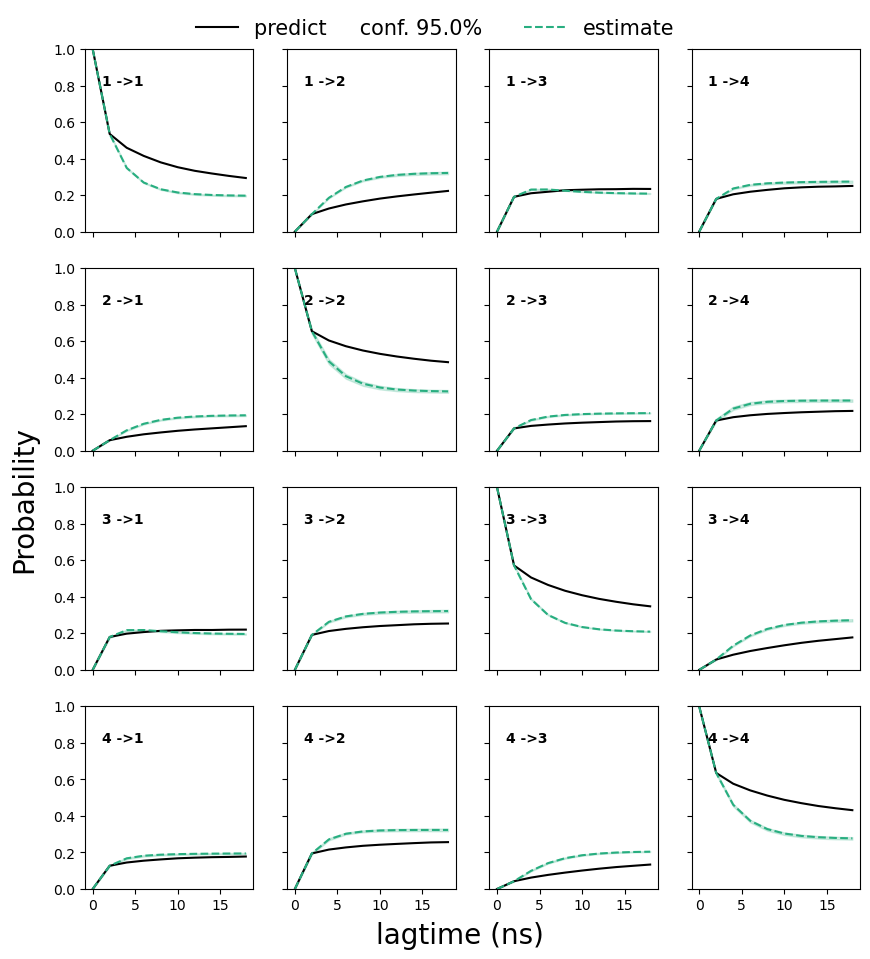

In [21]:
#plot customized CK plot
fig, ax =plot_cktest(ck,figsize=(10,10),padding_top= .05,units = "ns", dt = .2,
                                  padding_between = 0.2, y01=True,layout="wide")
for axi in ax.flat:
    axi.set_xlabel(None)
    axi.set_ylabel(None)
fig.supxlabel("lagtime (ns)",x=0.5,y=.05,size = 20)
fig.supylabel("Probability",x=.05,y=.5,size = 20)

In [22]:
#customize pyemma source code
from pyemma.util.statistics import confidence_interval as _conf
from pyemma.util.types import is_iterable_of_int as _is_iterable_of_int, is_int as _is_int
import numpy as _np
__author__ = 'noe'


def plot_implied_timescales(ITS, ax=None, outfile=None, show_mle=True, show_mean=True,
                            xlog=False, ylog=True, confidence=0.95, refs=None, nits=-1,
                            process=None, units='steps', dt=1., **kwargs):
    r"""Implied timescale plot
    Parameters
    ----------
    ITS : implied timescales object.
        Object whose data will be plotted. Should be of type :class:`ImpliedTimescales <pyemma.msm.ImpliedTimescales>`
        or a 3-tuple with: 1d array of lagtimes, (lagtimes, processes) array of timescales,
        optionally (lagtimes, processes, samples) array of timescales of samples.
    ax : matplotlib Axes object, optional, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    outfile : str, optional, default = None
        output file to write the figure to. When not given, the plot will be displayed
    show_mean : bool, default = True
        Line for mean value will be shown, if available
    show_mle : bool, default = True
        Line for maximum likelihood estimate will be shown
    xlog : bool, optional, default = False
        Iff true, the x-Axis is logarithmized
    ylog : bool, optional, default = True
        Iff true, the y-Axis is logarithmized
    confidence : float, optional, default = 0.95
        The confidence interval for plotting error bars (if available)
    refs : ndarray((m), dtype=float), optional, default = None
        Reference (exact solution or other reference) timescales if known. The number of timescales must match those
        in the ITS object
    nits: integer, default = -1
        Number of implied timescales to be shown. The default behaviour (-1) is to show all timescales available.
        :py:obj:`nits` != -1 and :py:obj:`process` != None are mutually exclusive
    process : iterable of integers, default is None
        list or ndarray((m), dtype=int) containing a list of the processes to be shown. The default behaviour is
        to show all timescales available.
        :py:obj:`process` != None and :py:obj:`nits` != -1 are mutually exclusive
    units: str or list (len=2) of strings, optional, default = 'steps'
        Affects the labeling of the axes. Used with :py:obj:`dt`, allows for changing the physical units of the axes.
        Accepts simple LaTeX math strings, eg. '$\mu$s'
        If this parameter is a list, it will be assumed that units[0] is for the x-axis and units[1] for the y-axis.
    dt: float or list(len=2) of floats, optional, default = 1.0
        Physical time between frames, expressed the units given in :py:obj:`units`. E.g, if you know that each
        frame corresponds to .010 ns, you can use the combination of parameters :py:obj:`dt` =0.01,
        :py:obj:`units` ='ns' to display the implied timescales in ns (instead of frames)
        If this parameter is a list, it will be assumed that dt[0] is for the x-axis and dt[1] for the y-axis.
    **kwargs: Will be passed to pyplot.plot when plotting the MLE datapoints (not the bootstrapped means).
            See the doc of pyplot for more options. Most useful lineproperties like `marker='o'` and/or :markersize=5
    Returns
    -------
    ax : Axes object containing the plot
    """
    if isinstance(ITS, tuple):
        assert len(ITS) in (2, 3)
        lags = _np.asarray(ITS[0])
        timescales = _np.asarray(ITS[1])
        timescales_samples = _np.asarray(ITS[2]) if len(ITS) == 3 and ITS[2] is not None else None
        n_timescales = timescales.shape[1]
        samples_available = timescales_samples is not None
    else:
        lags = ITS.lagtimes
        n_timescales = ITS.number_of_timescales
        timescales = ITS.get_timescales()
        samples_available = ITS.samples_available
        timescales_samples = ITS.timescales_samples
        if timescales_samples is not None:
            timescales_samples = timescales_samples.transpose(1, 2, 0)
    import matplotlib.pyplot as _plt
    # check input
    if ax is None:
        ax = _plt.gca(figsize= (10,6))
    colors = clist ######ADDED#####
    xmax = _np.max(lags)
    srt = _np.argsort(lags)
    # Check the processes to be shown
    if process is not None:
        if nits != -1:
            raise TypeError(
                'optional arguments nits and process are mutually exclusive:', nits, process)
        if not _is_iterable_of_int(process):
            raise ValueError('process has to be an iterable of integers')
        if _np.max(process)+1 > n_timescales:
            raise ValueError(
                'requested process %u, whereas ITS only contains %u timescales' % (
                    _np.max(process), n_timescales))
        # Now that it's for sure that nits==-1,
        # process is iter_of_ints, and the requested processes exist in its object:
        its_idx = process
    else:
        if not _is_int(nits):
            raise TypeError('nits is not an integer, ',nits)
        if nits == -1:
            nits = n_timescales
        its_idx = _np.arange(n_timescales)[:nits]
    # Check units and dt for user error.
    if isinstance(units, list) and len(units) != 2:
        raise TypeError("If units is a list, len(units) has to be = 2")
    if isinstance(dt, list) and len(dt) != 2:
        raise TypeError("If dt is a list, len(dt) has to be = 2")
    # Create list of units and dts for different axis
    if isinstance(units, str):
        units = [units] * 2
    if isinstance(dt, (float, int)):
        dt = [dt] * 2
    for i in its_idx:
        # plot estimate
        if show_mle:
            ax.plot(
                lags[srt] * dt[0], timescales[..., i][srt] * dt[1],
                color=colors[i % len(colors)], **kwargs)
        # sample available?
        if samples_available:
            # plot sample mean
            process_samples = timescales_samples[:, i, :].T
            if show_mean:
                sample_mean = _np.mean(process_samples, axis=0)
                ax.plot(
                    lags[srt] * dt[0], sample_mean[srt] * dt[1], marker='o',
                    color=colors[i % len(colors)], linestyle='dashed')
            lconf, rconf = _conf(process_samples, conf=confidence)
            ax.fill_between(
                lags[srt] * dt[0], lconf[srt] * dt[1], rconf[srt] * dt[1],
                alpha=0.2, color=colors[i % len(colors)])
        # reference available?
        if refs is not None:
            tref = refs[i] * dt[1]
            ax.plot([0, min(tref, xmax) * dt[0]], [tref, tref], color='black', linewidth=1)
    # cutoff
    ax.plot(lags[srt] * dt[0], lags[srt] * dt[1], linewidth=2, color='black')
    ax.set_xlim([1.0 * dt[0], xmax * dt[0]])
    ax.fill_between(
        lags[srt] * dt[0], ax.get_ylim()[0]*_np.ones(len(lags))*dt[1], lags[srt] * dt[1],
        alpha=0.2, color='grey')
    # formatting
    ax.set_xlabel('lag time / %s' % units[0])
    ax.set_ylabel('timescale / %s' % units[1])
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    # show or save
    if outfile is not None:
        _plt.savefig(outfile)
    return ax

estimating BayesianMSM:   0%|                                                                                 …

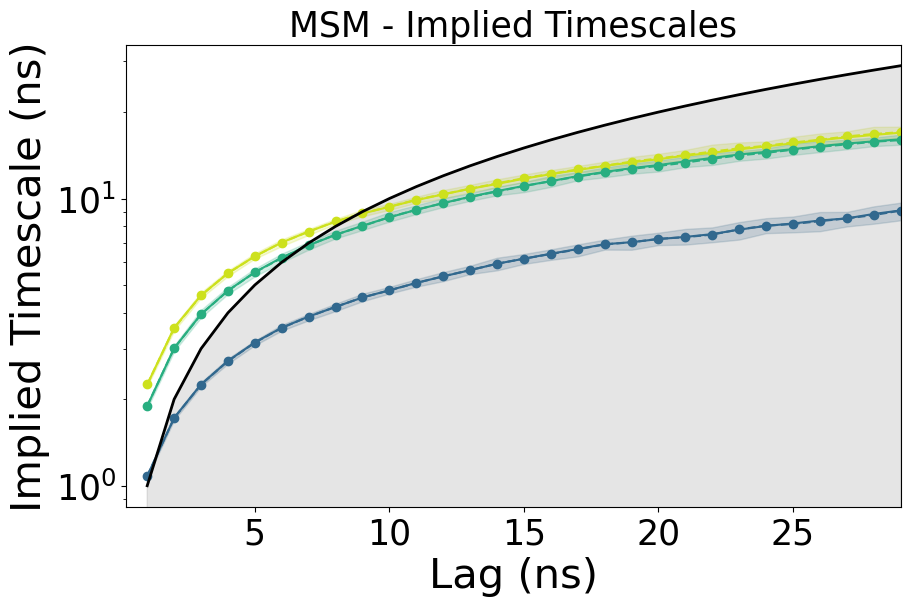

In [30]:
its = pyemma.msm.its(dtraj,np.arange(5,150,5),nits=nstates-1, errors="bayes", nsamples = 100,
                    n_jobs=1, )
fig,ax = plt.subplots(1,figsize=(10,6))
plot_implied_timescales(its,units="ns", dt=.2,ax=ax)
ax.set_xlabel("Lag (ns)",size=30)
ax.set_ylabel("Implied Timescale (ns)",size=30)
ax.set_title("MSM - Implied Timescales",size=25)
ax.tick_params("both", labelsize=25)

In [24]:
#stationary distribution errors
stat_error_l,stat_error_r = bmsm.sample_conf("stationary_distribution") #this estimate has the mean added to it
#above is a computation of the 95% confidence interval
stat_dist_mean = bmsm.sample_mean("stationary_distribution")
stat_dist_error = abs(np.stack([stat_error_l,stat_error_r]) - stat_dist_mean)




(0.5, 4.5)

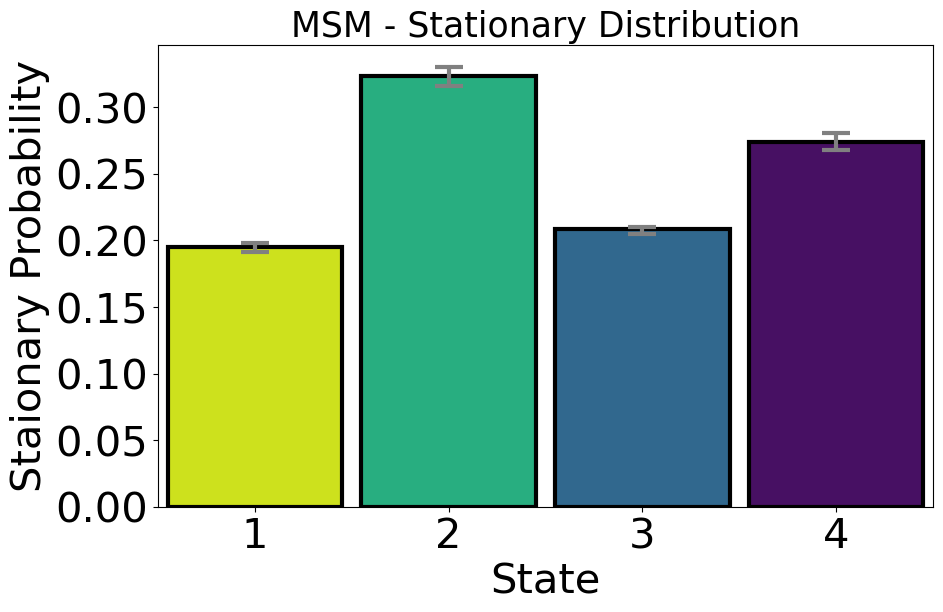

In [29]:
plt.figure(figsize = (10,6))
plt.bar(np.arange(1,nstates+1),stat_dist_mean,yerr = stat_dist_error,
        ecolor="grey",color=clist,capsize=10,width=.9,linewidth=3, edgecolor = "black",
        align="center",error_kw=dict(capthick=3,lw=3))
plt.xticks(np.arange(1,nstates+1), ticklabs)
plt.xlabel("State", size=30)
plt.ylabel("Staionary Probability", size=30)
plt.title("MSM - Stationary Distribution",size=25)
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.xlim(.5,nstates+.5)

In [26]:
def plot_mat_error(mat,emat,title,unit,cbarlabel,
                   textsize,textcolor,cmap,ticklabs):
        """mat = square matrix
        unit = string specifying the units"""
        fig,ax = plt.subplots(1,figsize=(20,20))
        s = ax.imshow(mat, cmap=cmap)
        for i in range(len(mat)):
            for j in range(len(mat)):
                c = mat[j, i]
                e = emat[j,i]
                ax.text(i, j,f"{np.round(c,1)}$\pm${np.round(e,2)}{unit}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax.set_yticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_xticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_ylabel(r"$State_{i}$", size=45)
        ax.set_xlabel(r"$State_{j}$", size=45)
        cb = plt.colorbar(s,ax=ax,label=cbarlabel,fraction=0.046,pad=0.04)
        cb.set_label(cbarlabel, size=40)
        cb.ax.tick_params(labelsize=30)
        ax.set_title(title, size = 45)
        plt.show()
        return

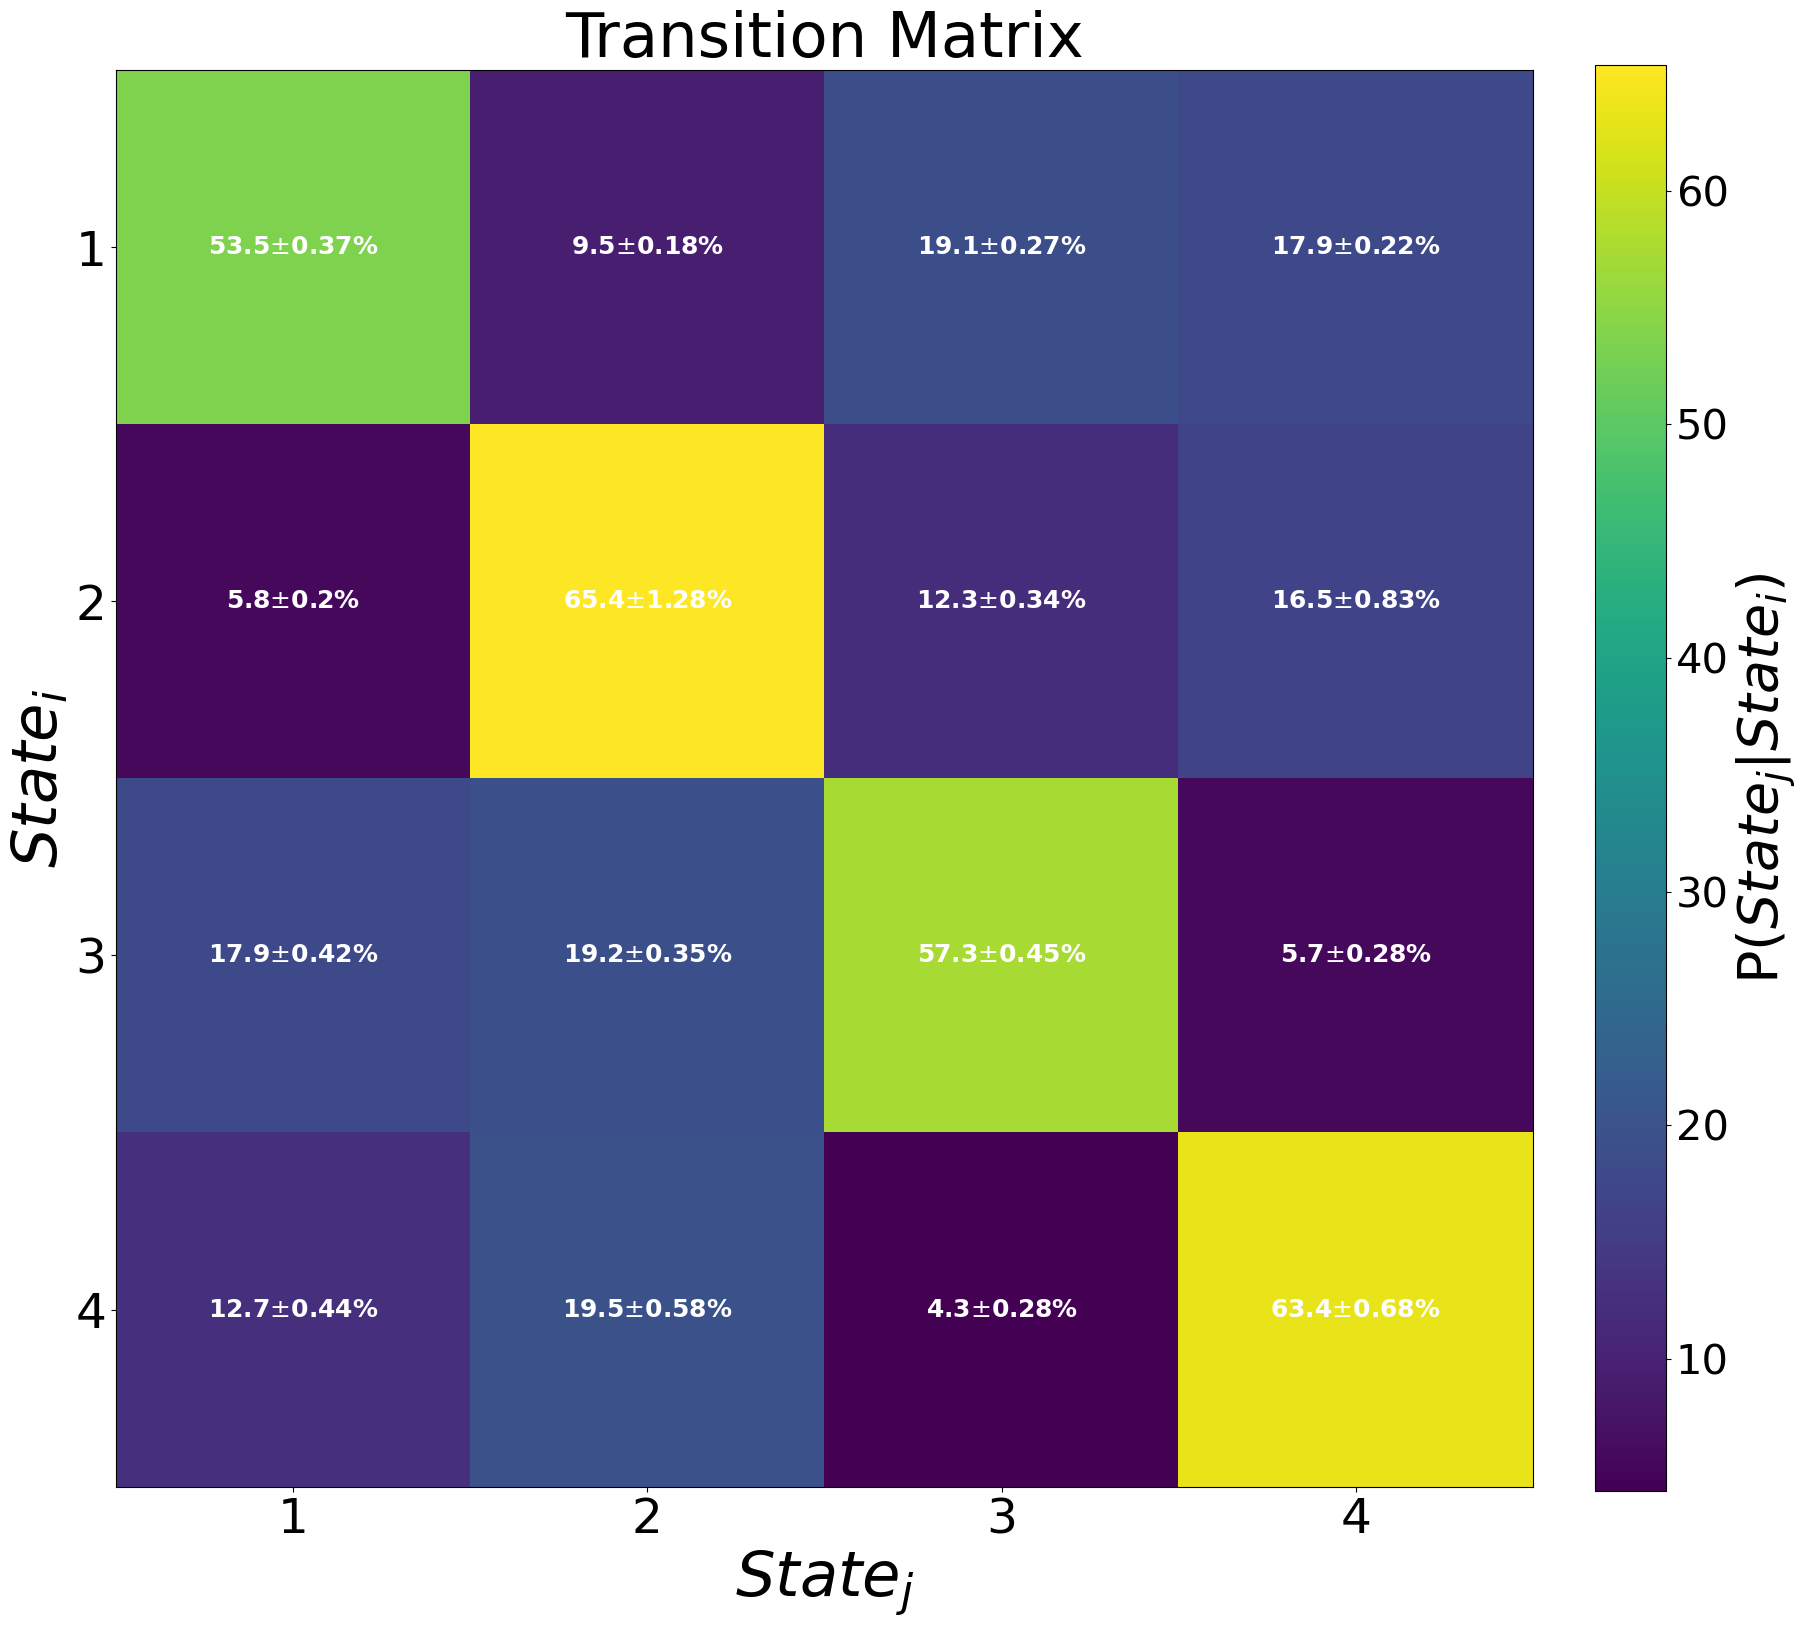

In [31]:
#transition matrix errors
tmat_l,tmat_r = bmsm.sample_conf("transition_matrix")
tmat = bmsm.sample_mean("transition_matrix")
rel_tmat_error = (abs(tmat-tmat_l)+abs(tmat-tmat_r))/2
tmat *= 100
rel_tmat_error *= 100

plot_mat_error(tmat,rel_tmat_error,"Transition Matrix","%",
               r"P($State_{j}$|$State_{i}$)",18,"white","viridis",ticklabs )

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


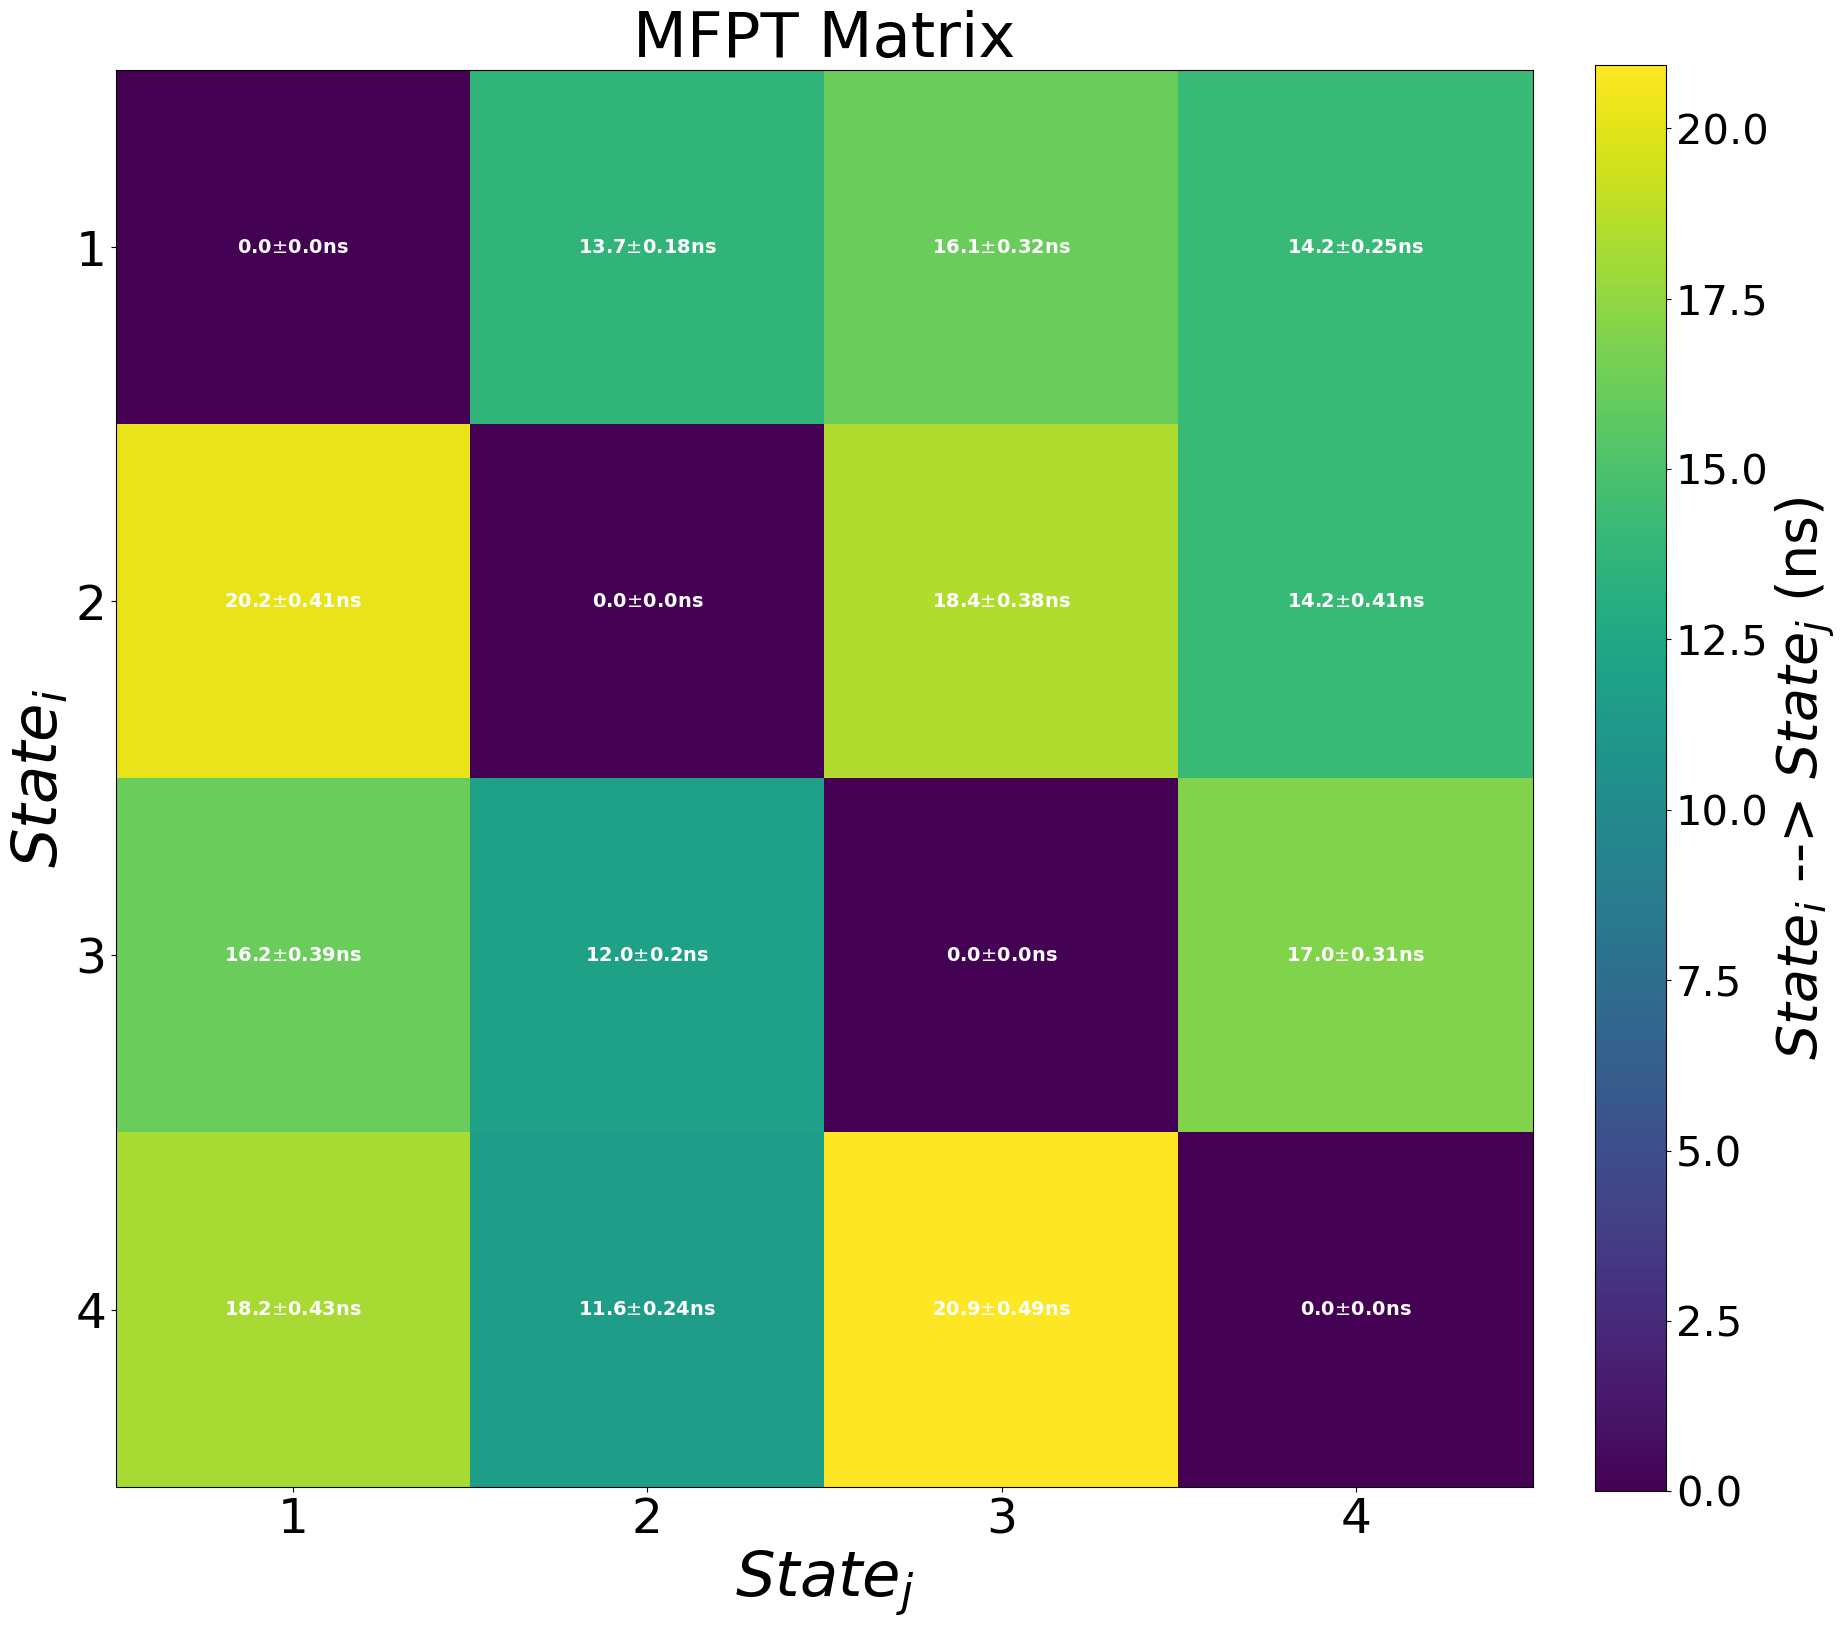

In [32]:
mfpt_error = np.zeros((nstates,nstates))
mfpt_mean = np.zeros((nstates,nstates))
for i in range(nstates):
    for j in range(nstates):
        mean = bmsm.sample_mean("mfpt", i,j)*(.2)
        mfpt_mean[i,j] = mean
        l,r = np.array(bmsm.sample_conf("mfpt", i,j))*(.2)
        mfpt_error[i,j] = (abs(mean-r)+abs(mean-l))/2
        
        
plot_mat_error(mfpt_mean,mfpt_error,"MFPT Matrix","ns",r"$State_{i}$ --> $State_{j}$ (ns)",
         14,"white","viridis",ticklabs)

In [29]:
#contact probabilities
dmat_con_prob = np.sum(dmat_bin, axis =0)/dmat.shape[0]
print (dmat_con_prob)
dmat_con_prob.shape

[0.046 0.065 0.101 0.088 0.175 0.129 0.142 0.115 0.102 0.118 0.119 0.091
 0.199 0.160 0.165 0.214 0.164 0.108 0.126 0.083]


(20,)

In [17]:
import deeptime
from deeptime.markov._observables import MembershipsObservable
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
from deeptime.plots import plot_ck_test
from deeptime.util.validation import ck_test
from deeptime.clustering import KMeans
from deeptime.decomposition import TICA
from deeptime.markov.msm import BayesianMSM

In [18]:
def plot_its_ck(dtraj,lag,n):
        lags = np.arange(lag,10*lag+1,lag)
        msms = []
        for l in lags:
            counts_est = TransitionCountEstimator(l,"sliding")
            c = counts_est.fit_fetch(dtraj)
            msm_estimator = MaximumLikelihoodMSM()
            msms.append(msm_estimator.fit_fetch(c))
        msm = msms[n]    
        fig,ax = plt.subplots(1,1,figsize=(10,5))
        its = implied_timescales(msms[:5])
        ax = plot_implied_timescales(its)
        ax.set_yscale("log")
        ax.set_xlabel("lag (steps)")
        ax.set_ylabel("timescales")
        ax.set_title("Implied Time Scales")
        plt.figure()
        observable = MembershipsObservable(test_model=msm, memberships=np.eye(msm.n_states))
        ck = ck_test(models=msms,observable=observable, test_model=msm)
        plot_ck_test(ck,sharey=True)
        
        return msm

In [19]:
dtraj

array([1, 1, 2, ..., 1, 1, 1], dtype=int32)

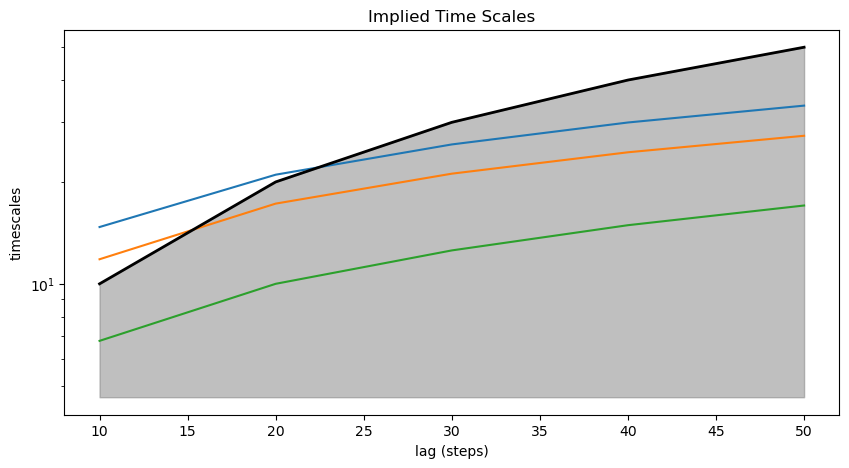

<Figure size 640x480 with 0 Axes>

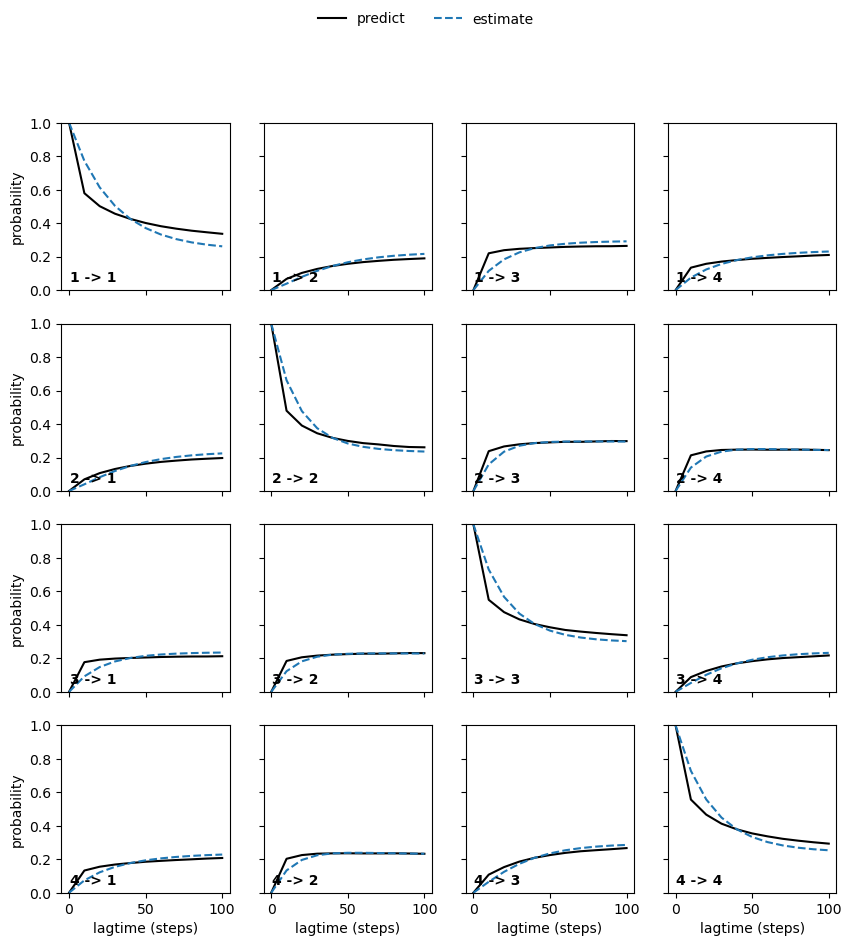

In [20]:
msm = plot_its_ck(dtraj,10,3)

In [23]:
def makem(ddtraj,nsets,lag):
    msm = pyemma.msm.estimate_markov_model(ddtraj, lag=lag)
    print(msm.score(ddtraj))
    #pyemma.plots.plot_cktest(msm.cktest(nsets=nsets,memberships=np.eye(nsets)))
    #plt.tight_layout()
    #plt.figure()
    lags_scale = np.arange(1,20)
    #its = pyemma.msm.its(ddtraj,lags = lags_scale, nits=nsets-1,errors = None)
    #pyemma.plots.plot_implied_timescales(its)
    return msm

In [24]:
#dmat
msm = makem(dtraj, 4, 10)

05-12-22 19:54:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[0] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
1.6862418817214706


([<matplotlib.axis.XTick at 0x7fe6bf66e920>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

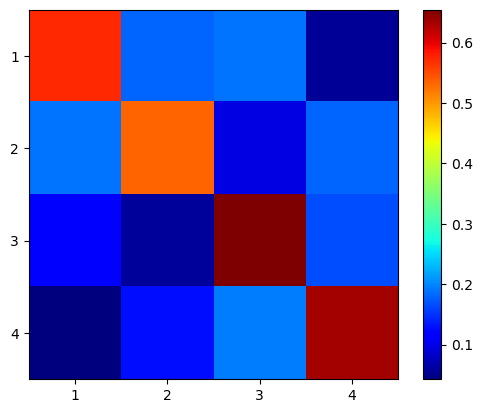

In [25]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [26]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 80.16875895914906
mfpt 0-2 is 59.97476847074918
mfpt 0-3 is 84.57120054778643
mfpt 1-0 is 81.56830284319015
mfpt 1-2 is 68.43226538132606
mfpt 1-3 is 70.61360813707392
mfpt 2-0 is 93.4325049034632
mfpt 2-1 is 100.49045792999897
mfpt 2-3 is 70.61442607426682
mfpt 3-0 is 105.76835100879597
mfpt 3-1 is 90.41121471404236
mfpt 3-2 is 58.35384010256235


In [27]:
#dmat
msm = makem(dtraj, 4, 50)

05-12-22 19:55:01 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[1] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
1.2309138793082963


([<matplotlib.axis.XTick at 0x7fe6c81f42b0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

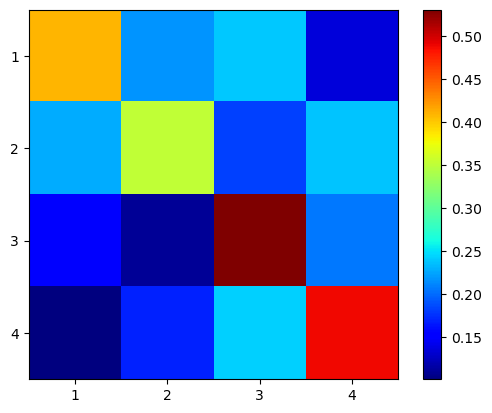

In [28]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [29]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 295.8904790623056
mfpt 0-2 is 220.67952710889466
mfpt 0-3 is 278.8808025353324
mfpt 1-0 is 300.73050940076314
mfpt 1-2 is 235.00756160933634
mfpt 1-3 is 247.47067084671417
mfpt 2-0 is 333.1895500778935
mfpt 2-1 is 342.6775542398776
mfpt 2-3 is 255.3772550656152
mfpt 3-0 is 354.56561134470394
mfpt 3-1 is 318.3154493176281
mfpt 3-2 is 218.55204090598792


In [30]:
#dmat
msm = makem(dtraj, 4, 100)

05-12-22 19:55:06 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[2] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
1.1051810782110294


([<matplotlib.axis.XTick at 0x7fe6c89b7a60>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

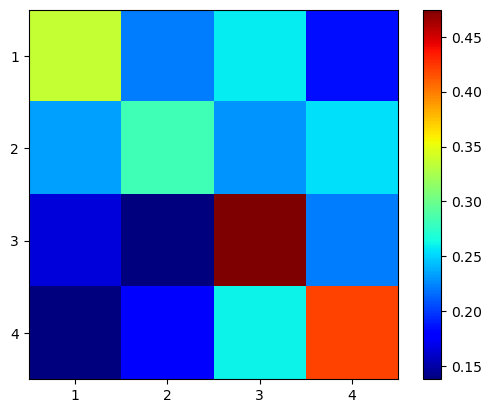

In [31]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [32]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 542.908165016932
mfpt 0-2 is 396.3360076377653
mfpt 0-3 is 473.6466967790463
mfpt 1-0 is 544.2175067185022
mfpt 1-2 is 408.1202579936164
mfpt 1-3 is 438.80795781471454
mfpt 2-0 is 591.2924140596973
mfpt 2-1 is 601.7673227139782
mfpt 2-3 is 454.77338684556975
mfpt 3-0 is 608.2140931992219
mfpt 3-1 is 572.0660125333198
mfpt 3-2 is 394.3843768438132
